In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
from sklearn.metrics import silhouette_score


In [ ]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [ ]:
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens.to(device))
    embeddings = output.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings


In [ ]:
df['bert_embedding'] = df['message'].apply(get_bert_embedding)


In [ ]:
X = np.vstack(df['bert_embedding'].to_numpy())

In [ ]:
X

array([[ 0.08564048, -0.5351515 ,  0.5795286 , ..., -0.0522707 ,
         0.29215226, -0.03900453],
       [ 0.07416045, -0.2920679 ,  0.28948653, ...,  0.15055181,
        -0.07654782,  0.05337835],
       [ 0.07410222, -0.06461929,  0.81856906, ..., -0.1393411 ,
         0.02458197,  0.22032973],
       ...,
       [ 0.16393188, -0.05190447,  0.34867454, ...,  0.07627543,
         0.05241312, -0.04477345],
       [ 0.10472482, -0.25824246,  0.10970839, ..., -0.22135712,
         0.10682324, -0.14448419],
       [-0.06863373, -0.34529015, -0.11418188, ...,  0.02042714,
         0.49969855,  0.20645097]], dtype=float32)

In [ ]:
len(X[0])

768

In [ ]:
len(X)

5572

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)

In [ ]:
reduced_embeddings

array([[-2.581741  ,  1.1839374 ],
       [-2.359544  ,  3.1294918 ],
       [-2.6151574 , -2.338916  ],
       ...,
       [ 0.5977206 ,  0.53605056],
       [ 0.87354034, -0.9414855 ],
       [-0.5256156 ,  0.9281802 ]], dtype=float32)

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [ ]:
cluster_labels = kmeans.labels_

In [ ]:
cluster_labels

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [ ]:
silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

In [ ]:
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.36229804158210754


In [ ]:
df['cluster']=kmeans.labels_

In [ ]:
df

,label,message,label_num,bert_embedding,cluster
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[[0.085640475, -0.5351515, 0.5795286, 0.154611...",0
1,ham,Ok lar... Joking wif u oni...,0,"[[0.07416045, -0.2920679, 0.28948653, -0.52406...",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[[0.074102215, -0.06461929, 0.81856906, -0.223...",0
3,ham,U dun say so early hor... U c already then say...,0,"[[0.004471338, 0.1264876, 0.5696162, -0.317123...",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[[0.3242445, 0.40917158, 0.08880487, -0.021922...",1
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,"[[0.053443346, 0.017069781, 0.6745061, -0.3401...",0
5568,ham,Will Ì_ b going to esplanade fr home?,0,"[[0.13152607, -0.11885103, 0.89884967, 0.07674...",0
5569,ham,"Pity, * was in mood for that. So...any other s...",0,"[[0.16393188, -0.051904473, 0.34867454, -0.007...",1
5570,ham,The guy did some bitching but I acted like i'd...,0,"[[0.10472482, -0.25824246, 0.10970839, 0.32693...",1


<ipython-input-43-7455d2b1e7f5>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
<ipython-input-43-7455d2b1e7f5>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)


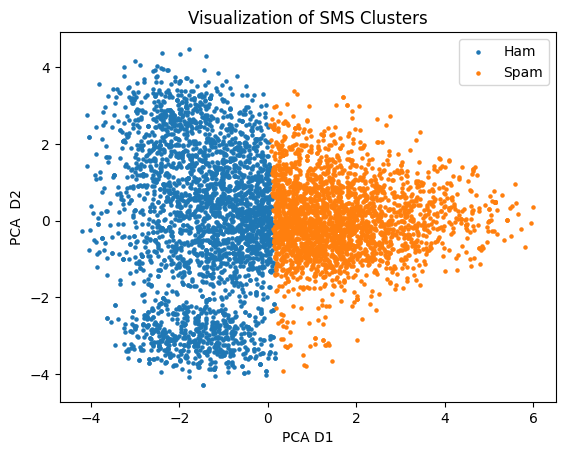

In [ ]:
ham_indices = df[df['cluster'] == 0].index
spam_indices = df[df['cluster'] == 1].index
import matplotlib.pyplot as plt


plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)

plt.title('Visualization of SMS Clusters')
plt.legend()
plt.xlabel('PCA D1')
plt.ylabel('PCA  D2')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

accuracy=accuracy_score(df['label_num'],df['cluster'])
report=classification_report(df['label_num'], df['cluster'])

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')


Accuracy: 0.4244436468054559
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.48      0.59      4825
           1       0.02      0.08      0.04       747

    accuracy                           0.42      5572
   macro avg       0.40      0.28      0.31      5572
weighted avg       0.67      0.42      0.52      5572

